In [57]:
#Ucitavanje biblioteka

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.offline import iplot, plot
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from kneed import KneeLocator
import time
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import StandardScaler, RobustScaler


In [58]:
#Ucitavanje csv fajla

data = pd.read_csv('songs_normalize.csv')
data.head(4)

,artist,song,duration_ms,explicit,year,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre
0,Britney Spears,Oops!...I Did It Again,211160,False,2000,77,0.751,0.834,1,-5.444,0,0.0437,0.3000,0.000018,0.355,0.894,95.053,pop
1,blink-182,All The Small Things,167066,False,1999,79,0.434,0.897,0,-4.918,1,0.0488,0.0103,0.000000,0.612,0.684,148.726,"rock, pop"
2,Faith Hill,Breathe,250546,False,1999,66,0.529,0.496,7,-9.007,1,0.0290,0.1730,0.000000,0.251,0.278,136.859,"pop, country"
3,Bon Jovi,It's My Life,224493,False,2000,78,0.551,0.913,0,-4.063,0,0.0466,0.0263,0.000013,0.347,0.544,119.992,"rock, metal"


In [59]:
#Izmjena naziva kolona, capslk

data.rename(columns={'artist':'Artist', 'song':'Song', 'duration_ms':'Duration_MS', 'explicit':'Explicit', 
                     'year':'Year','popularity':'Popularity','danceability':'Danceability',
                     'energy':'Energy', 'key':'Key', 'loudness':'Loudness', 'mode':'Mode', 
                     'speechiness':'Speechiness', 'acousticness':'Acousticness', 
                     'instrumentalness':'Instrumentalness', 'liveness':'Liveness', 
                     'valence':'Valence', 'tempo':'Tempo','genre':'Genre'},inplace=True)

In [60]:
#Duplikati

data.duplicated().sum()

59

In [61]:
#Brisanje duplikata

data.drop_duplicates(inplace=True)

In [62]:
#Koliko je pjesama izvan opsega 2000-2019

years_of_interest = [1999, 1998, 2020]
filtered_data = data[data['Year'].isin(years_of_interest)]

song_year = filtered_data['Year'].value_counts().reset_index()
song_year.columns = ['Year', 'Number of songs']

song_year

,Year,Number of songs
0,1999,38
1,2020,3
2,1998,1


In [63]:
#Posto nas zanimaju samo godine od 2000-2019, brisemo godine izvan tog opsega

data_years_drop = data[(data['Year'] <2000) | (data['Year'] > 2009)].index
data = data.drop(data_years_drop)
print(data.Year.unique())

[2000 2001 2002 2004 2006 2008 2003 2005 2007 2009]


In [64]:
data.shape

(906, 18)

In [65]:
filtered_data = data[data['Popularity'] > 0]

#Brisanje pjesama sa popularnoscu nula
data = filtered_data.reset_index(drop=True)


In [66]:
data.describe()

,Duration_MS,Year,Popularity,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo
count,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000
mean,239271.716063,2004.502262,61.559955,0.666138,0.731804,5.339367,-5.523707,0.564480,0.110250,0.125073,0.020278,0.185698,0.595354,118.392283
std,40075.727674,2.800865,13.235296,0.151613,0.152208,3.527307,1.943955,0.496106,0.101743,0.166675,0.105432,0.149468,0.218738,28.407027
min,127920.000000,2000.000000,1.000000,0.129000,0.058100,0.000000,-17.217000,0.000000,0.023900,0.000021,0.000000,0.023400,0.040600,60.019000
25%,212236.500000,2002.000000,56.000000,0.567000,0.639750,2.000000,-6.516500,0.000000,0.038550,0.011375,0.000000,0.084075,0.435000,95.818500
50%,233986.500000,2004.000000,63.000000,0.674000,0.744500,6.000000,-5.322000,1.000000,0.063750,0.054100,0.000000,0.128000,0.609000,116.986000
75%,259733.250000,2007.000000,70.000000,0.775250,0.853000,8.000000,-4.209750,1.000000,0.144250,0.178250,0.000096,0.247250,0.774250,134.596750
max,452906.000000,2009.000000,87.000000,0.975000,0.999000,11.000000,-0.276000,1.000000,0.576000,0.976000,0.985000,0.843000,0.973000,210.851000


In [67]:
features = ['Loudness','Acousticness', 'Instrumentalness','Valence','Speechiness','Tempo']
X = data[features]

#Koristimo StandardScaler
scaler = MinMaxScaler()
X_scaled= scaler.fit_transform(X)
X_s = pd.DataFrame(X_scaled)
X_s


,0,1,2,3,4,5
0,0.694941,0.307362,0.000018,0.915272,0.035863,0.232272
1,0.776459,0.026926,0.000014,0.539897,0.041116,0.397615
2,0.732601,0.041783,0.001056,0.899185,0.050172,0.746771
3,0.765775,0.030922,0.000000,0.771557,0.060315,0.294931
4,0.764595,0.027336,0.000000,0.879880,0.015034,0.285191
...,...,...,...,...,...,...
879,0.652500,0.104489,0.000000,0.553840,0.491034,0.583338
880,0.615076,0.028156,0.000000,0.462677,0.036225,0.796217
881,0.556815,0.758192,0.000039,0.108752,0.018475,0.218150
882,0.842276,0.027951,0.000000,0.964607,0.028618,0.212104


Najbolji Silhouette Score: 0.260 za broj klastera: 4


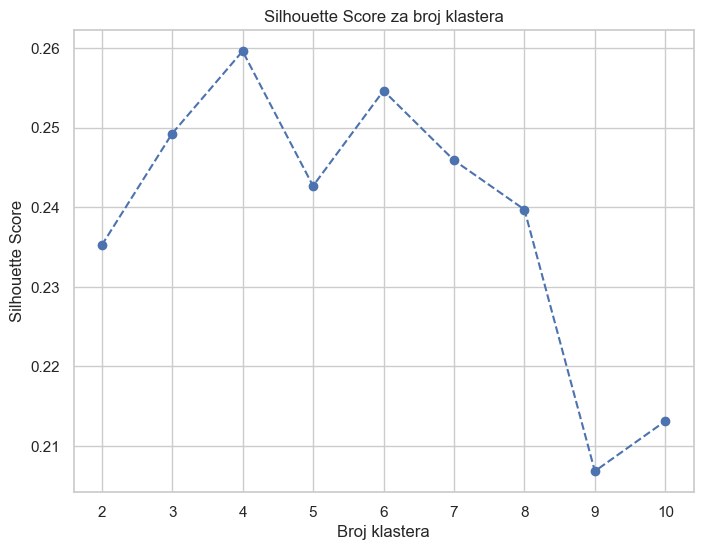

In [68]:
#Silhoutte score kmeans++


silhouette_scores = []

for i in range(2, 11):
    kmeans=KMeans(n_clusters=i, init='k-means++', n_init = 50)
    labels = kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, labels)
    silhouette_scores.append(silhouette_avg)

max_silhouette_score = max(silhouette_scores)
optimal_clusters = silhouette_scores.index(max_silhouette_score) + 2  

print(f"Najbolji Silhouette Score: {max_silhouette_score:.3f} za broj klastera: {optimal_clusters}")

plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='--')
plt.title('Silhouette Score za broj klastera')
plt.xlabel('Broj klastera')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

In [69]:
#from sklearn.cluster import KMeans
#import seaborn as sns

#pca = PCA(n_components=2)

#_pca = pca.fit_transform(X_scaled)

# Promijenite metodu inicijalizacije centara klastera na 'random'
# Defaultna metoda je 'k-means++'
#kmeans = KMeans(n_clusters=3, init='random',  max_iter=10000, tol=1e-4, random_state=1)
#clusters = kmeans.fit_predict(X_pca)
#data['Cluster'] = clusters

# Vizualizacija klastera
#plt.figure(figsize=(10, 6))
#sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=data['Cluster'], palette='viridis', s=50)
#plt.title('Klasteri')
#plt.legend(title='Klaster')
#plt.show()


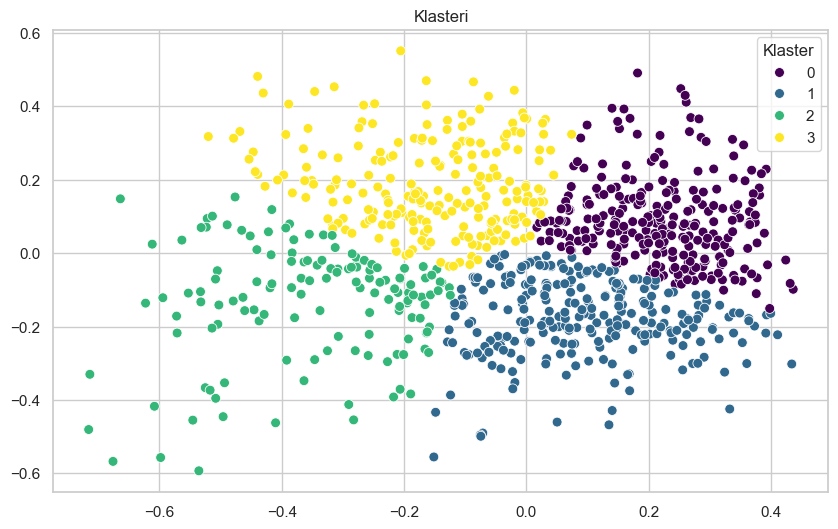

In [70]:
#Klasteri

pca = PCA(n_components=2)

X_pca = pca.fit_transform(X_scaled)

kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', n_init=50)
clusters = kmeans.fit_predict(X_pca)
data['Cluster'] = clusters

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=data['Cluster'], palette='viridis', s=50)
plt.title('Klasteri')
plt.legend(title='Klaster')
plt.show()

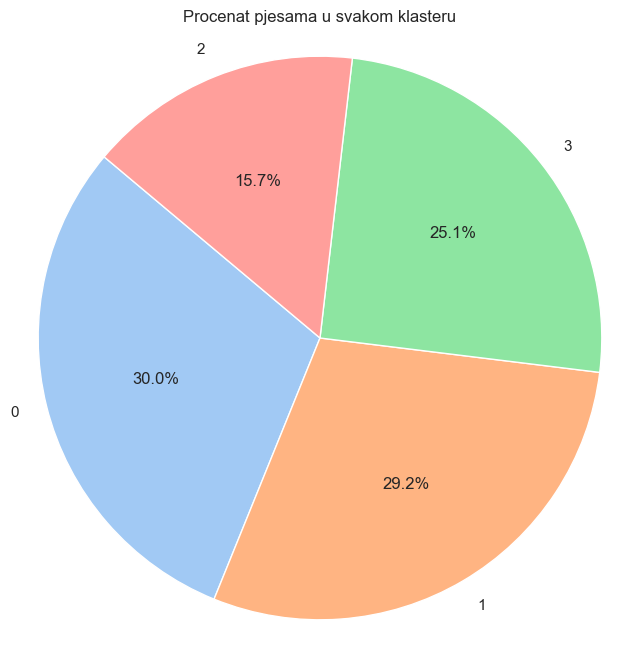

In [71]:
#Raposdjela pjesama

cluster_counts = data['Cluster'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(cluster_counts, labels=cluster_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("pastel", len(cluster_counts)))
plt.title('Procenat pjesama u svakom klasteru')
plt.axis('equal')
plt.show()

In [72]:
cluster_means = data.groupby('Cluster')[features].mean()
cluster_means

,Loudness,Acousticness,Instrumentalness,Valence,Speechiness,Tempo
Cluster,,,,,,
0,-4.959645,0.073398,0.031635,0.804079,0.102742,128.523423
1,-5.797426,0.167773,0.005741,0.668279,0.166190,94.468174
2,-6.526806,0.252592,0.020087,0.297718,0.059939,103.301705
3,-5.250851,0.057289,0.023738,0.447809,0.085704,143.551104


In [73]:
cluster_0_songs = data[data['Cluster'] == 0][['Song', 'Artist']].head(5)
print(cluster_0_songs)

cluster_1_songs = data[data['Cluster'] == 1][['Song', 'Artist']].head(5)
print(cluster_1_songs)

cluster_2_songs = data[data['Cluster'] == 2][['Song', 'Artist']].head(5)
print(cluster_2_songs)

lewis = data[data['Artist']=='Red Hot Chili Peppers'][['Song','Cluster']]
lewis



                     Song           Artist
2             Bye Bye Bye           *NSYNC
3     The Real Slim Shady           Eminem
4                 Rock DJ  Robbie Williams
5  Lady - Hear Me Tonight            Modjo
8        Better Off Alone     Alice Deejay
                            Song          Artist
0         Oops!...I Did It Again  Britney Spears
7                      Try Again         Aaliyah
11                   Cold as Ice          M.O.P.
14  What'chu Like (feat. Tyrese)         Da Brat
15               The Time Is Now          Moloko
                                 Song       Artist
24  Case Of The Ex (Whatcha Gonna Do)          Mýa
43                             I Wish  Carl Thomas
47                        Pure Shores   All Saints
77                      It's Over Now          112
96              Until The End Of Time         2Pac


,Song,Cluster
185,Can't Stop,0
218,By the Way,2
578,Dani California,0
687,Snow (Hey Oh),1


In [74]:
# Prvo, sortirajte podatke prema klasteru i popularnosti
sorted_data = data.sort_values(by=['Cluster', 'Popularity'], ascending=[True, False])

# Zatim, grupišite sortirane podatke po klasterima
grouped_data = sorted_data.groupby('Cluster')

# Sada, prolazite kroz svaku grupu (klaster) i odaberite tri najpopularnije pjesme
top_songs_per_cluster = {}
for cluster, group in grouped_data:
    top_songs_per_cluster[cluster] = group.head(7)

# Ispisivanje tri najpopularnije pjesme iz svakog klastera
for cluster, top_songs in top_songs_per_cluster.items():
    print(f"\nCluster {cluster}:")
    print(top_songs[['Song', 'Artist','Popularity']])



Cluster 0:
                     Song          Artist  Popularity
147            Without Me          Eminem          87
3     The Real Slim Shady          Eminem          86
447        Feel Good Inc.        Gorillaz          82
527           Promiscuous   Nelly Furtado          82
801  Empire State Of Mind           JAY-Z          82
330                 Toxic  Britney Spears          81
609          Say It Right   Nelly Furtado          81

Cluster 1:
                                   Song      Artist  Popularity
60                                 Stan      Eminem          83
85                          Ms. Jackson     Outkast          82
513  Hips Don't Lie (feat. Wyclef Jean)     Shakira          82
790                           Heartless  Kanye West          82
236                          In Da Club     50 Cent          81
328    Yeah! (feat. Lil Jon & Ludacris)       Usher          81
331                             Hey Ya!     Outkast          80

Cluster 2:
                   S

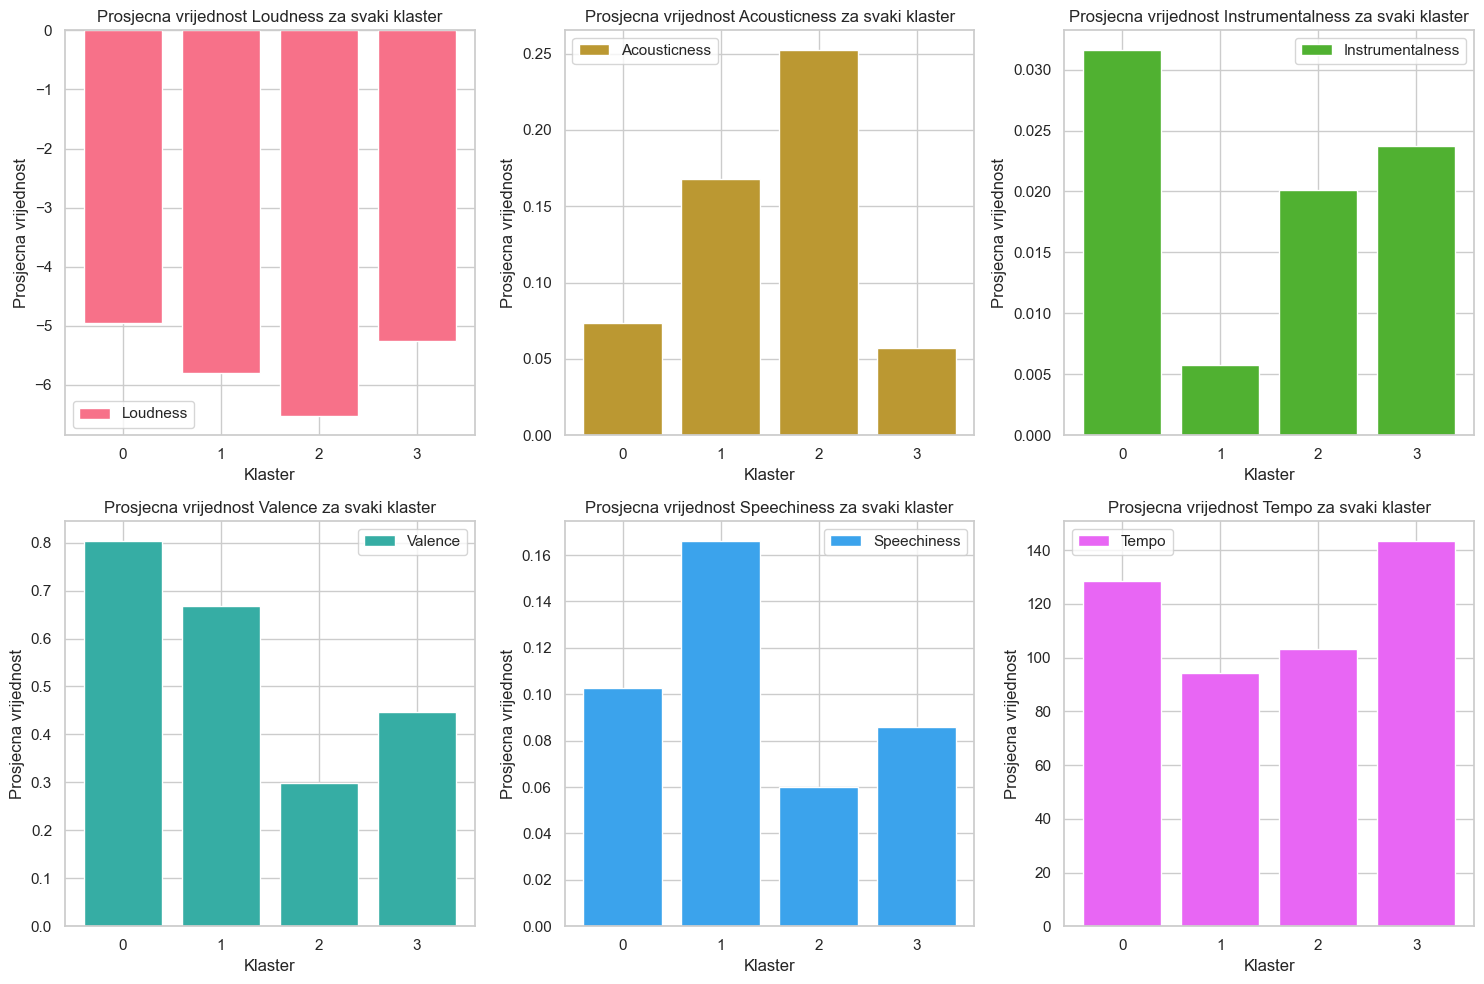

In [75]:
#Raspodjela karakteristika po klasterima

cluster_means = data.groupby('Cluster')[features].mean()

sns.set(style="whitegrid")
colors = sns.color_palette("husl", len(features))

num_cols = min(len(features), 3)
num_rows = (len(features) + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows*5))

for i, feature in enumerate(features):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col] if num_rows > 1 else axes[col]
    
    ax.bar(cluster_means.index, cluster_means[feature], color=colors[i], label=feature)
    ax.set_xlabel('Klaster')
    ax.set_ylabel('Prosjecna vrijednost')
    ax.set_title(f'Prosjecna vrijednost {feature} za svaki klaster')
    ax.set_xticks(cluster_means.index) 
    ax.set_xticklabels(cluster_means.index)
    ax.legend()


plt.tight_layout()
plt.show()

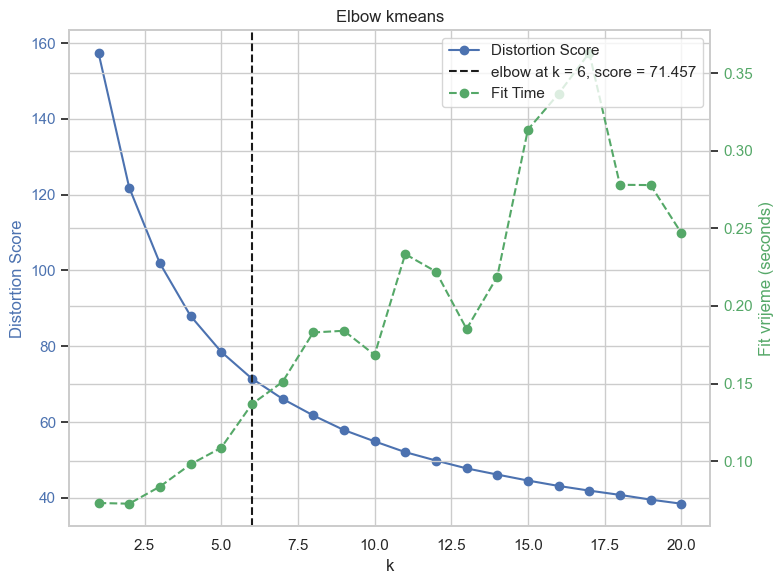

Optimalan broj klastera: 6


In [76]:
#Elbow metoda

distortion_scores = []
fit_times = []

for i in range(1, 21):
    start_time = time.time()
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=50)
    kmeans.fit(X_scaled)
    end_time = time.time()
    distortion_scores.append(kmeans.inertia_)
    fit_times.append(end_time - start_time)

fig, ax1 = plt.subplots(figsize=(8, 6))

ax1.plot(range(1, 21), distortion_scores, 'b-o', label='Distortion Score')
ax1.set_xlabel('k')
ax1.set_ylabel('Distortion Score', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_title('Elbow kmeans')

kneedle = KneeLocator(range(1, 21), distortion_scores, curve='convex', direction='decreasing')
optimal_clustersEL = kneedle.elbow
ax1.axvline(x=optimal_clustersEL, color='k', linestyle='--', label=f'elbow at k = {optimal_clustersEL}, score = {distortion_scores[optimal_clustersEL-1]:.3f}')

ax2 = ax1.twinx()
ax2.plot(range(1, 21), fit_times, 'g--o', label='Fit Time')
ax2.set_ylabel('Fit vrijeme (seconds)', color='g')
ax2.tick_params(axis='y', labelcolor='g')
fig.tight_layout()
fig.legend(loc='upper right', bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.grid(True)
plt.show()
print(f"Optimalan broj klastera: {optimal_clustersEL}")

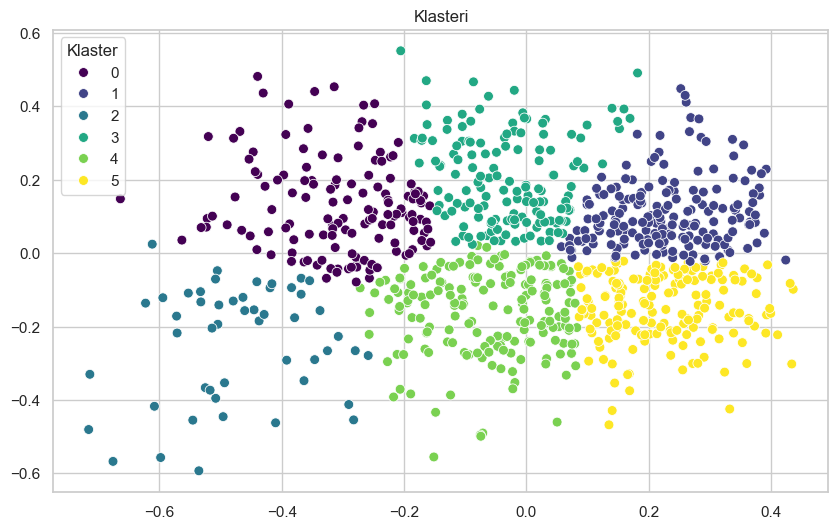

In [77]:
#Klasteri

pca = PCA(n_components=2)

X_pca = pca.fit_transform(X_scaled)

kmeans = KMeans(n_clusters=optimal_clustersEL,init='k-means++',n_init=50)
clusters = kmeans.fit_predict(X_pca)
data['ClusterE'] = clusters

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=data['ClusterE'], palette='viridis', s=50)
plt.title('Klasteri')
plt.legend(title='Klaster')
plt.show()

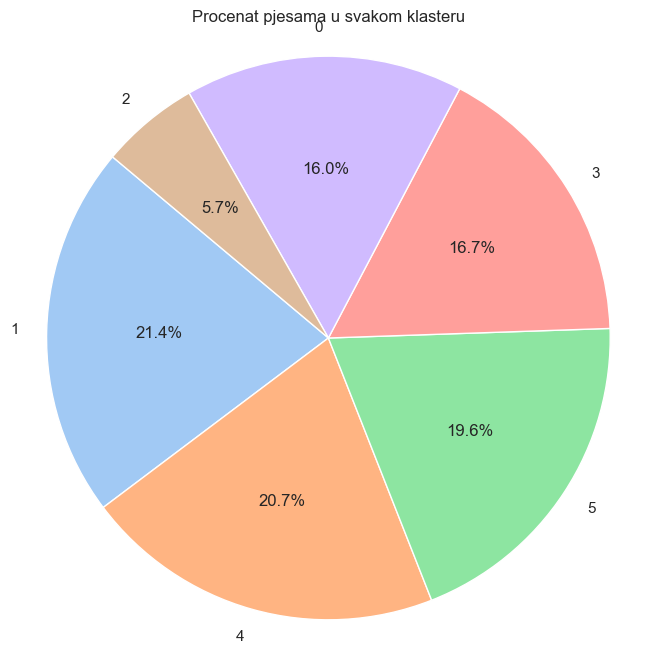

In [78]:
#Raposdjela pjesama

cluster_counts = data['ClusterE'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(cluster_counts, labels=cluster_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("pastel", len(cluster_counts)))
plt.title('Procenat pjesama u svakom klasteru')
plt.axis('equal')
plt.show()

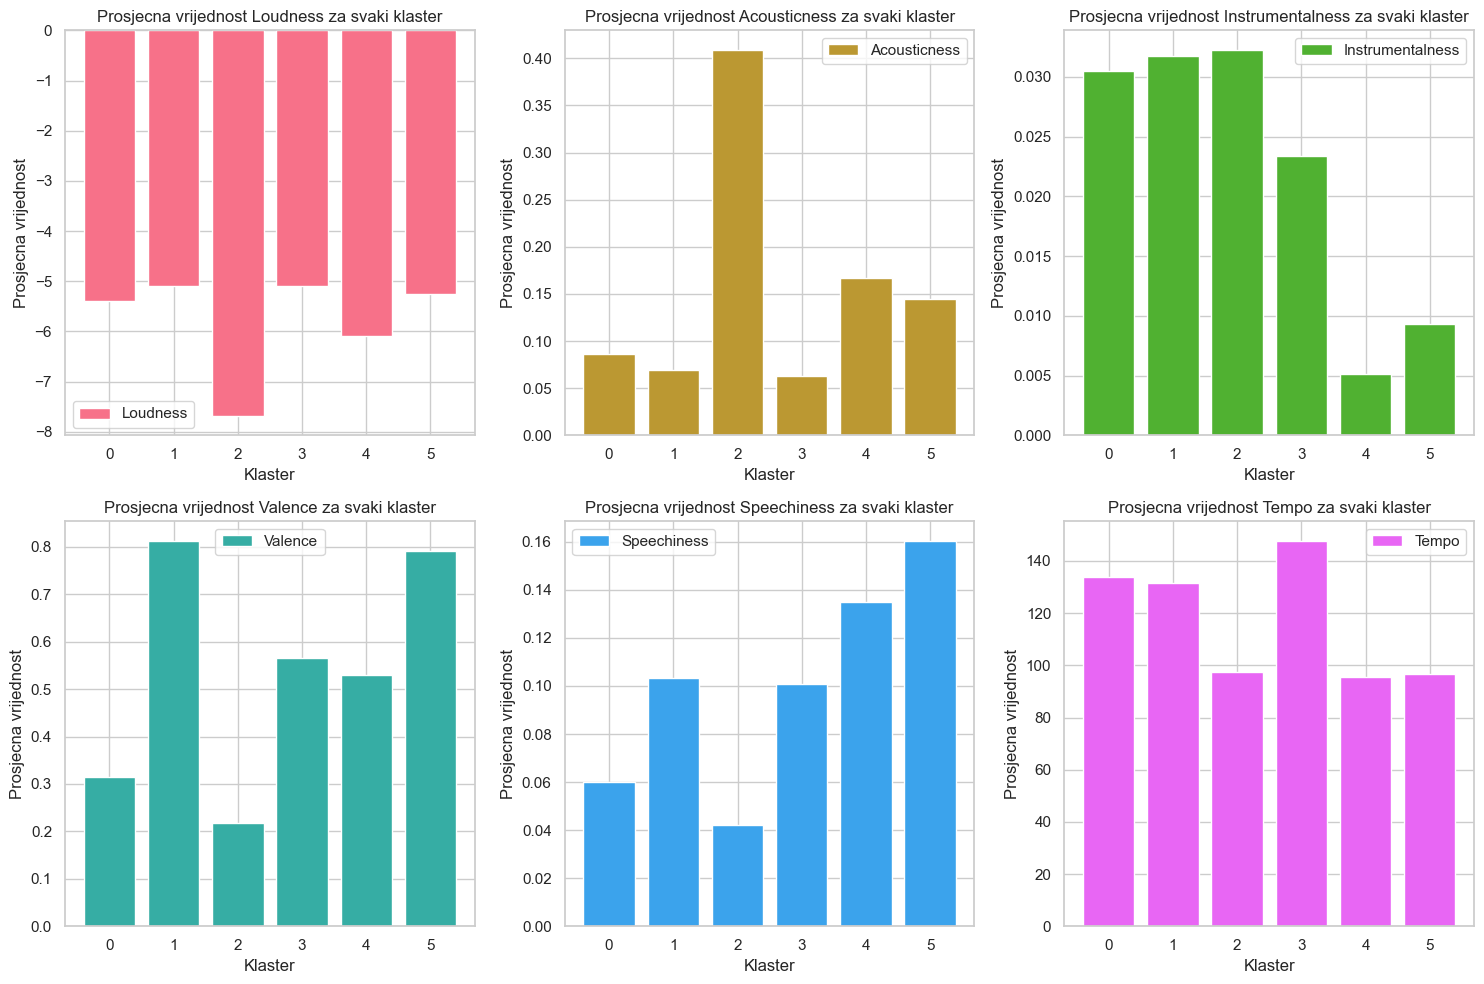

In [79]:
#Raspodjela karakteristika po klasterima

cluster_means = data.groupby('ClusterE')[features].mean()

sns.set(style="whitegrid")
colors = sns.color_palette("husl", len(features))

num_cols = min(len(features), 3)
num_rows = (len(features) + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows*5))

for i, feature in enumerate(features):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col] if num_rows > 1 else axes[col]
    
    ax.bar(cluster_means.index, cluster_means[feature], color=colors[i], label=feature)
    ax.set_xlabel('Klaster')
    ax.set_ylabel('Prosjecna vrijednost')
    ax.set_title(f'Prosjecna vrijednost {feature} za svaki klaster')
    ax.set_xticks(cluster_means.index) 
    ax.set_xticklabels(cluster_means.index)
    ax.legend()


plt.tight_layout()
plt.show()

In [80]:
cluster_means = data.groupby('ClusterE')[features].mean()
cluster_means

,Loudness,Acousticness,Instrumentalness,Valence,Speechiness,Tempo
ClusterE,,,,,,
0,-5.399809,0.086288,0.030465,0.314008,0.060137,133.773277
1,-5.088217,0.068842,0.031771,0.812942,0.103172,131.681931
2,-7.684240,0.409113,0.032270,0.217924,0.042128,97.416820
3,-5.090878,0.063268,0.023384,0.566541,0.100709,147.759932
4,-6.086142,0.167118,0.005151,0.529464,0.135037,95.460410
5,-5.251358,0.144421,0.009299,0.790382,0.160460,96.533497


In [81]:
# Prvo, sortirajte podatke prema klasteru i popularnosti
sorted_data = data.sort_values(by=['ClusterE', 'Popularity'], ascending=[True, False])

# Zatim, grupišite sortirane podatke po klasterima
grouped_data = sorted_data.groupby('ClusterE')

# Sada, prolazite kroz svaku grupu (klaster) i odaberite tri najpopularnije pjesme
top_songs_per_cluster = {}
for cluster, group in grouped_data:
    top_songs_per_cluster[cluster] = group.head(7)

# Ispisivanje tri najpopularnije pjesme iz svakog klastera
for cluster, top_songs in top_songs_per_cluster.items():
    print(f"\nCluster {cluster}:")
    print(top_songs[['Song', 'Artist','Popularity']])



Cluster 0:
                   Song         Artist  Popularity
155    'Till I Collapse         Eminem          85
9            In the End    Linkin Park          83
343                Numb    Linkin Park          81
689  Low (feat. T-Pain)       Flo Rida          80
761        Viva La Vida       Coldplay          80
762         Sex on Fire  Kings of Leon          80
252    Bring Me To Life    Evanescence          79

Cluster 1:
                     Song          Artist  Popularity
147            Without Me          Eminem          87
3     The Real Slim Shady          Eminem          86
447        Feel Good Inc.        Gorillaz          82
527           Promiscuous   Nelly Furtado          82
801  Empire State Of Mind           JAY-Z          82
330                 Toxic  Britney Spears          81
609          Say It Right   Nelly Furtado          81

Cluster 2:
                  Song           Artist  Popularity
207             Clocks         Coldplay          79
332         The Reas

In [82]:
data.head(100)

,Artist,Song,Duration_MS,Explicit,Year,Popularity,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Genre,Cluster,ClusterE
0,Britney Spears,Oops!...I Did It Again,211160,False,2000,77,0.751,0.834,1,-5.444,0,0.0437,0.30000,0.000018,0.3550,0.894,95.053,pop,1,5
1,Bon Jovi,It's My Life,224493,False,2000,78,0.551,0.913,0,-4.063,0,0.0466,0.02630,0.000013,0.3470,0.544,119.992,"rock, metal",3,3
2,*NSYNC,Bye Bye Bye,200560,False,2000,65,0.614,0.928,8,-4.806,0,0.0516,0.04080,0.001040,0.0845,0.879,172.656,pop,0,1
3,Eminem,The Real Slim Shady,284200,True,2000,86,0.949,0.661,5,-4.244,0,0.0572,0.03020,0.000000,0.0454,0.760,104.504,hip hop,0,1
4,Robbie Williams,Rock DJ,258560,False,2000,68,0.708,0.772,7,-4.264,1,0.0322,0.02670,0.000000,0.4670,0.861,103.035,"pop, rock",0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Gorillaz,Clint Eastwood,340920,True,2001,74,0.663,0.694,10,-8.627,0,0.1710,0.02530,0.000000,0.0698,0.525,167.953,hip hop,3,3
96,2Pac,Until The End Of Time,266506,True,2001,57,0.757,0.706,8,-6.665,1,0.2030,0.02670,0.000000,0.1970,0.375,96.976,hip hop,2,4
97,Tamia,Stranger in My House,285386,False,2000,48,0.676,0.601,0,-4.905,1,0.0297,0.10300,0.000000,0.1470,0.206,119.940,"pop, R&B",2,0
98,Mary J. Blige,No More Drama,326240,False,2001,61,0.653,0.837,6,-6.818,0,0.1240,0.53400,0.000071,0.0784,0.640,97.914,"pop, R&B",1,4


In [83]:
different_clusters = data[(data['Cluster'] ==3) & (data['ClusterE']==4)][['Song', 'Cluster', 'ClusterE']]

# Ispisivanje rezultata
print("Pjesme koje nisu u istim klasterima u klasterima i hijerarhijskim klasterima:")
print(different_clusters)


Pjesme koje nisu u istim klasterima u klasterima i hijerarhijskim klasterima:
                            Song  Cluster  ClusterE
12            Take A Look Around        3         4
223                  Hands Clean        3         4
299  How You Gonna Act Like That        3         4
352                   Headsprung        3         4
384                  Take Me Out        3         4
549               Control Myself        3         4
665                         Ruby        3         4
668                    Face Down        3         4
852          Party In The U.S.A.        3         4


In [84]:

# Grupisanje podataka po ClusterE i Cluster
grouped = data.groupby('ClusterE')




